In [4]:
# Importing libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [5]:
# Loading datasets
train_df = pd.read_csv('/Users/jamille.ghazaleh/Downloads/Github/football_analysis/1-avaliacao-pratica-2-2024-ml-uniceub/train_futebol.csv')
test_df = pd.read_csv('/Users/jamille.ghazaleh/Downloads/Github/football_analysis/1-avaliacao-pratica-2-2024-ml-uniceub/test_futebol.csv')
submission_df = pd.read_csv('/Users/jamille.ghazaleh/Downloads/Github/football_analysis/1-avaliacao-pratica-2-2024-ml-uniceub/sample_submission.csv')
print(train_df.head())

         Home      Away  Round        Date   Time   WIN  minuto       evento  \
0  Birmingham  West Ham     38  11.05.2003  16:00  Draw      27  Yellow_Away   
1  Birmingham  West Ham     38  11.05.2003  16:00  Draw      57  Yellow_Home   
2  Birmingham  West Ham     38  11.05.2003  16:00  Draw      66    Goal_Away   
3  Birmingham  West Ham     38  11.05.2003  16:00  Draw      80    Goal_Home   
4  Birmingham  West Ham     38  11.05.2003  16:00  Draw      88    Goal_Home   

   Yellow_Away  Yellow_Home  Goal_Away  Goal_Home  Red_Card_Away  \
0            1            0          0          0              0   
1            1            1          0          0              0   
2            1            1          1          0              0   
3            1            1          1          1              0   
4            1            1          1          2              0   

   Red_Card_Home  Own_Home  Own_Away  Penalty_Missed_Home  \
0              0         0         0             

-----------------------------------------------------------

EDA

In [6]:
# Understanding dimensions
print(train_df.shape)

(40330, 20)


In [7]:
# Statistics
print(train_df.describe())

              Round        minuto   Yellow_Away   Yellow_Home     Goal_Away  \
count  40330.000000  40330.000000  40330.000000  40330.000000  40330.000000   
mean      18.978031     54.656534      1.157575      0.926878      0.799207   
std       10.954710     25.333753      1.136995      1.026580      0.938274   
min        1.000000      0.000000      0.000000      0.000000      0.000000   
25%        9.000000     35.000000      0.000000      0.000000      0.000000   
50%       19.000000     57.000000      1.000000      1.000000      1.000000   
75%       28.000000     77.000000      2.000000      1.000000      1.000000   
max       38.000000    101.000000      9.000000      7.000000      9.000000   

          Goal_Home  Red_Card_Away  Red_Card_Home      Own_Home      Own_Away  \
count  40330.000000   40330.000000   40330.000000  40330.000000  40330.000000   
mean       1.026382       0.054947       0.038978      0.040863      0.029259   
std        1.063413       0.235162       0.20

In [8]:
# Data cleaning
print(train_df.isnull().sum())

Home                   0
Away                   0
Round                  0
Date                   0
Time                   0
WIN                    0
minuto                 0
evento                 0
Yellow_Away            0
Yellow_Home            0
Goal_Away              0
Goal_Home              0
Red_Card_Away          0
Red_Card_Home          0
Own_Home               0
Own_Away               0
Penalty_Missed_Home    0
Penalty_Missed_Away    0
Var_Home               0
Var_Away               0
dtype: int64


In [9]:
# Understanding type of data 
print(train_df.dtypes)

Home                   object
Away                   object
Round                   int64
Date                   object
Time                   object
WIN                    object
minuto                  int64
evento                 object
Yellow_Away             int64
Yellow_Home             int64
Goal_Away               int64
Goal_Home               int64
Red_Card_Away           int64
Red_Card_Home           int64
Own_Home                int64
Own_Away                int64
Penalty_Missed_Home     int64
Penalty_Missed_Away     int64
Var_Home                int64
Var_Away                int64
dtype: object


-----------------------------------------------------------

In [10]:
# Defining the target variable 'Win'
train_df['WIN'] = train_df.apply(lambda row: 'Win' if row['Goal_Home'] > row['Goal_Away'] else ('Lose' if row['Goal_Home'] < row['Goal_Away'] else 'Draw'), axis=1)

train_df = train_df.dropna(subset=['WIN'])

# Defining the features (X) and target (y)
X = train_df.drop(columns=['WIN'])
y = train_df['WIN']


In [11]:
# Converting categorical columns to dummies
X = pd.get_dummies(X, drop_first=True)
X_test = pd.get_dummies(test_df, drop_first=True)

In [12]:
X_test = X_test.reindex(columns=X.columns, fill_value=0)

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

-------------------

In [13]:
# Setting numeric columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

In [14]:
# Scaling the numerical columns
scaler = StandardScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns

# Applying the scaler to the training data
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [15]:
# Initialize the RandomForestClassifier with a fixed random state for reproducibility.
best_params = {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_train, y_train)

# Evaluation on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8613935035953385
              precision    recall  f1-score   support

        Draw       1.00      0.63      0.77      2467
        Lose       0.96      0.91      0.94      2332
         Win       0.76      1.00      0.86      3267

    accuracy                           0.86      8066
   macro avg       0.91      0.85      0.86      8066
weighted avg       0.89      0.86      0.86      8066



In [16]:
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy}')
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8613935035953385
              precision    recall  f1-score   support

        Draw       1.00      0.63      0.77      2467
        Lose       0.96      0.91      0.94      2332
         Win       0.76      1.00      0.86      3267

    accuracy                           0.86      8066
   macro avg       0.91      0.85      0.86      8066
weighted avg       0.89      0.86      0.86      8066



In [17]:
# Make predictions on the test set
X_test = test_df.reindex(columns=X_train.columns, fill_value=0)
test_predictions = model.predict(X_test)

# Save the predictions for submission
submission_df['WIN'] = test_predictions
submission_df.to_csv('submission.csv', index=False)

In [18]:
print(submission_df.head())

   index  WIN
0      0  Win
1      1  Win
2      2  Win
3      3  Win
4      4  Win


--------

In [19]:
# Print the count of each unique value in the target variable 'y'
print(y.value_counts())

Win     16517
Draw    12416
Lose    11397
Name: WIN, dtype: int64


In [20]:
# Check the accuracy on the training set
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

Training Accuracy: 0.8900322340689313


In [21]:
# Perform cross-validation on the model using the training data
scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Average Accuracy with Cross-Validation: {scores.mean()}')

Average Accuracy with Cross-Validation: 0.8645858666735071


In [22]:
for depth in [3, 5, 7, 10]:
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Accuracy with Decision Tree (max_depth={depth}): {accuracy}')


Accuracy with Decision Tree (max_depth=3): 0.8860649640466154
Accuracy with Decision Tree (max_depth=5): 0.9841309199107364
Accuracy with Decision Tree (max_depth=7): 0.9973964790478552
Accuracy with Decision Tree (max_depth=10): 0.9998760228118027


In [23]:
# Initialize a DecisionTreeClassifier with a maximum depth of 3
model = DecisionTreeClassifier(max_depth=10)
model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy with Decision Tree: {accuracy}')

Accuracy with Decision Tree: 0.9997520456236053


In [24]:
# Oversampling with SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [25]:
# Print the classification report for the validation set predictions
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

        Draw       1.00      1.00      1.00      2467
        Lose       1.00      1.00      1.00      2332
         Win       1.00      1.00      1.00      3267

    accuracy                           1.00      8066
   macro avg       1.00      1.00      1.00      8066
weighted avg       1.00      1.00      1.00      8066



Overfitting (MSE): 0.020
Underfitting (MSE): 0.229
Balanced (MSE): 0.026


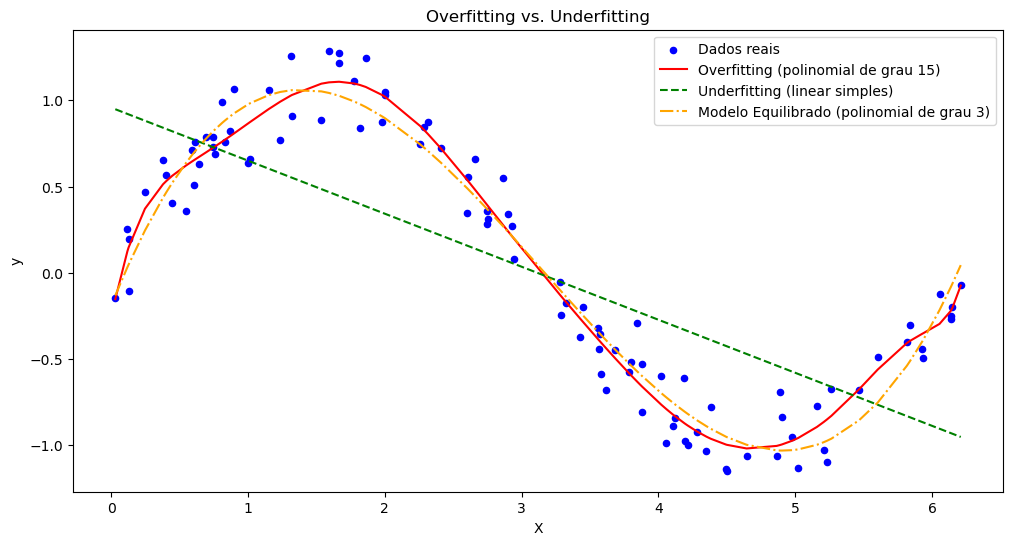

In [26]:
# Generating some data
np.random.seed(0)
X = np.sort(2 * np.pi * np.random.rand(100, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.15, X.shape[0])

X_sorted = np.sort(X, axis=0)

# Overfitting model:
overfitting_model = make_pipeline(PolynomialFeatures(15), LinearRegression())
overfitting_model.fit(X, y)
overfitting_predictions = overfitting_model.predict(X_sorted)

# Underfitting model:
underfitting_model = LinearRegression()
underfitting_model.fit(X, y)
underfitting_predictions = underfitting_model.predict(X_sorted)

# Balanced model:
balanced_model = make_pipeline(PolynomialFeatures(3), LinearRegression())
balanced_model.fit(X, y)
balanced_predictions = balanced_model.predict(X_sorted)

# Calculating (MSE) for both models.
mse_overfitting = mean_squared_error(y, overfitting_model.predict(X))
mse_underfitting = mean_squared_error(y, underfitting_model.predict(X))
mse_balanced = mean_squared_error(y, balanced_model.predict(X))

# Printing 
print(f"Overfitting (MSE): {mse_overfitting:.3f}")
print(f"Underfitting (MSE): {mse_underfitting:.3f}")
print(f"Balanced (MSE): {mse_balanced:.3f}")

# Plotting results
plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='blue', s=20, label='Dados reais')  # Plotando os dados reais
plt.plot(X_sorted, overfitting_predictions, color='red', label='Overfitting (polinomial de grau 15)')  # Plotando as previsões do modelo overfitting
plt.plot(X_sorted, underfitting_predictions, color='green', linestyle='--', label='Underfitting (linear simples)')  # Plotando as previsões do modelo underfitting
plt.plot(X_sorted, balanced_predictions, color='orange', linestyle='-.', label='Modelo Equilibrado (polinomial de grau 3)')  # Plotando as previsões do modelo equilibrado
plt.xlabel('X')
plt.ylabel('y')
plt.title('Overfitting vs. Underfitting')
plt.legend() 
plt.show() 

In [39]:
def metricas_classificacao(y_real, y_pred):
    # Calculate classification metrics
    metrics = {
        "Acurácia": accuracy_score(y_real, y_pred),  # Accuracy metric
        "Precisão (macro)": precision_score(y_real, y_pred, average='macro'),  # Precision metric (macro average)
        "Recall (macro)": recall_score(y_real, y_pred, average='macro'),  # Recall metric (macro average)
        "F1-Score (macro)": f1_score(y_real, y_pred, average='macro')  # F1-Score metric (macro average)
    }
    
    # Print metrics
    for key, value in metrics.items():
        print(f"{key}: {value}")

    # Calculate the confusion matrix
    confusion_mat = confusion_matrix(y_real, y_pred)

    # Print the confusion matrix
    print("Confusion Matrix:")
    sns.heatmap(confusion_mat, annot=True, cmap='YlGnBu', fmt='g')  # Plot confusion matrix with heatmap
    plt.xlabel('Predicted')  # Set x-axis label
    plt.ylabel('Actual')  # Set y-axis label
    plt.show(block=True)  # Show the plot

    return metrics  # Return the dictionary containing all metrics

Acurácia: 0.9997520456236053
Precisão (macro): 0.9997219443017181
Recall (macro): 0.9997219443017181
F1-Score (macro): 0.9997219443017181
Matriz de Confusão:


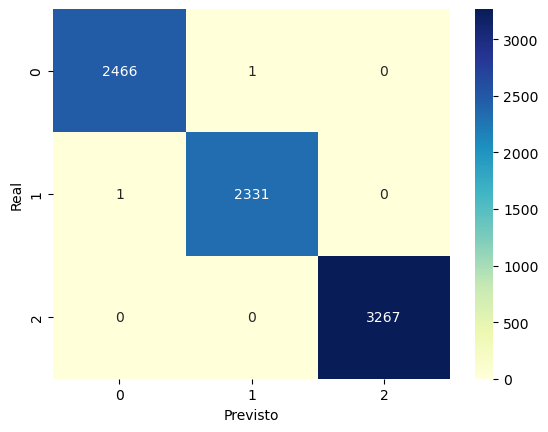

{'Acurácia': 0.9997520456236053,
 'Precisão (macro)': 0.9997219443017181,
 'Recall (macro)': 0.9997219443017181,
 'F1-Score (macro)': 0.9997219443017181}

In [40]:
y_val_pred = model.predict(X_val)
metricas_classificacao(y_val, y_val_pred)